<h1> Introduction </h1>

The objective of this data analysis is to gain valuable insights into the current job market for Software Engineers and Web Developers. The data was collected by web scraping from the Indeed website on July 25th, 2023. The analysis includes information such as job titles, company details, locations, job types, salary ranges, and the specific skills required for each job posting. The search terms used for web scraping include "Software Engineer," "Software Developer," and "Web Developer." Additionally, the results were filtered to include only postings that were posted within the last 14 days to ensure the data reflects current job opportunities.

<h3> Installation </h3>

In [1]:
# !pip install spacy
# !pip install --upgrade pip

<h3> Import Statements </h3>

In [2]:
import pandas as pd
import spacy
nlp = spacy.load('en_core_web_sm')
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import re

/Users/meihuang/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h3> Notebook Presentation </h3>

In [143]:
pd.options.display.float_format = '{:,.2f}'.format

<h3> Reading data </h3>

In [4]:
df_data = pd.read_csv('software_engineer_jobs_USA.csv',sep=';')

<h3> Data Exploration </h3>

In [5]:
print(f'(Rows,Columns): {df_data.shape}')

(Rows,Columns): (3556, 5)


In [6]:
df_data.tail(5)

,job_title,company_name,company_location,salary,skills
3551,Software Developer,"CSSI, Inc.","Washington, DC 20024 \n(Southwest Waterfront a...",NaN,"['JavaScript', 'Java', 'C#', 'Go', 'SQL', 'CSS..."
3552,Software Engineer,Calfus,"Pleasanton, CA",NaN,"['Java', 'Go', 'SQL', 'NoSQL', 'React', 'Node...."
3553,Python Developer,Gatix E Solution,"Texas City, TX",$30 - $60 an hour,"['Python', 'JavaScript', 'Java', 'Go', 'SQL', ..."
3554,Associate Software Engineer,McKesson,"Atlanta, GA 30329",$38.08 - $63.46 an hour,"['JavaScript', 'Java', 'C#', 'Go', 'TypeScript..."
3555,Software Engineer,"X-Force, LLC.","Fort Leavenworth, KS 66027",$50 an hour,"['JavaScript', 'Java', 'C#', 'SQL', 'HTML', 'A..."


In [7]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3556 entries, 0 to 3555
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   job_title         3556 non-null   object
 1   company_name      3556 non-null   object
 2   company_location  3556 non-null   object
 3   salary            1964 non-null   object
 4   skills            3556 non-null   object
dtypes: object(5)
memory usage: 139.0+ KB


<h3> Check for Nan Values and Duplicates </h3>

In [8]:
print(f'Missing values?: {df_data.isna().values.any()}')
df_data.isna().sum()

Missing values?: True


job_title              0
company_name           0
company_location       0
salary              1592
skills                 0
dtype: int64

In [9]:
print(f'Duplicate values?: {df_data.duplicated().values.any()}')
df_data.duplicated().sum()

Duplicate values?: True


1979

<h2> Data Cleaning </h2> 

<h4> Drop data with empty values </h4>

In [10]:
df_data_clean = df_data.dropna()
df_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 3555
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   job_title         1964 non-null   object
 1   company_name      1964 non-null   object
 2   company_location  1964 non-null   object
 3   salary            1964 non-null   object
 4   skills            1964 non-null   object
dtypes: object(5)
memory usage: 92.1+ KB


<h4> Drop duplicate data with the same company name and job title </h4>

In [11]:
df_data_clean.drop_duplicates(subset=['company_name', 'job_title', 'company_location'],inplace=True)
df_data_clean.shape

/var/folders/wx/n3nghw29261195fbm316p8xm0000gn/T/ipykernel_21556/1019937765.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_clean.drop_duplicates(subset=['company_name', 'job_title', 'company_location'],inplace=True)


(842, 5)

In [12]:
df_data_clean.sample(5)

,job_title,company_name,company_location,salary,skills
1184,Automation Validation Engineer,eTeam Inc,"Tucson, AZ",$50 - $55 an hour,"['Linux', 'Windows']"
2931,Software Developer (.NET Full-Stack: Mobile/We...,Vesigo Studios,"Medford, OR 97504 \n(Rogue Valley Internationa...","$72,000 - $90,000 a year","['JavaScript', 'Java', 'C#', 'Go', 'SQL', 'HTM..."
1767,Embedded Flight Software Engineer,CI Software,"Pasadena, CA",$75 - $95 an hour,"['Python', 'C++']"
1294,Software Development Engineer,Sensydia,Remote,"From $135,000 a year","['Python', 'Swift', 'Go', 'Linux']"
2063,Sr. Full Stack Java Developer,Synergis,"Hybrid remote in Atlanta, GA 30361","$110,357 - $132,903 a year","['JavaScript', 'Java', 'Go', 'TypeScript', 'SQ..."


<h3> Extract minimum salary for each job </h3>

In [126]:
# Create a new column called salary min 
df_data_clean.loc['salary_min'] = df_data_clean['salary'].str.split('-').str[0]
df_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 843 entries, 0 to salary_min
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   job_title         842 non-null    object 
 1   company_name      842 non-null    object 
 2   company_location  842 non-null    object 
 3   salary            842 non-null    object 
 4   skills            842 non-null    object 
 5   salary_min        842 non-null    float64
 6   state             711 non-null    object 
 7   work_mode         842 non-null    object 
dtypes: float64(1), object(7)
memory usage: 59.3+ KB


/var/folders/wx/n3nghw29261195fbm316p8xm0000gn/T/ipykernel_21556/1401394022.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
df_data_clean.sample(5)

,job_title,company_name,company_location,salary,skills,salary_min
459,Software Engineer,Oxford Global Resources,"Boxborough, MA",$60 - $65 an hour,"['Java', 'C++', 'SQL']",$60
52,Principal Software Engineer - Data Security (S...,GloComms,"Remote in San Francisco, CA","$350,000 - $600,000 a year","['Python', 'SQL', 'NoSQL']","$350,000"
1000,Senior Software Engineer,LifeScience Logistics,"Coppell, TX 75019","$120,000 - $140,000 a year","['Python', 'JavaScript', 'Java', 'C++', 'C#', ...","$120,000"
363,Embedded Software Engineer,Enin Systems,"Bear, DE 19701","$70,396 - $162,522 a year",['Go'],"$70,396"
1929,Staff Software Engineer II (Developer Platform),Coupang,"Seattle, WA 98101 \n(Denny Triangle area)","From $142,000 a year","['Python', 'Java', 'C++', 'Go', 'JSON', 'AWS',...","From $142,000 a year"


In [15]:
def extractNum(text):
    firstchar = str(text).split(" ")[0]
    if firstchar == "From":
        return text.split(" ")[1]
    elif firstchar == "Up":
        return text.split(" ")[2]
    else:
        return firstchar 

In [16]:
df_data_clean.sample(5)

,job_title,company_name,company_location,salary,skills,salary_min
2071,Web Developer,MyServiceGuru LLC,"Orem, UT 84058 \n(Orem Park area)","$58,526 - $63,853 a year","['JavaScript', 'Java', 'Go', 'HTML', 'CSS', 'A...","$58,526"
584,Software Engineer,Moore & Associates,"Poway, CA 92064","$100,000 - $140,000 a year","['Python', 'C#', 'Linux', 'Windows']","$100,000"
1287,"Sr Engineers, Software",T-Mobile,"Overland Park, KS 66251","$126,328 a year","['Python', 'JavaScript', 'Java', 'C#', 'PHP', ...","$126,328 a year"
2199,Web & UX Designer,Texas State University,"San Marcos, TX 78666","$5,135 a month","['Go', 'Git']","$5,135 a month"
361,Software Engineer,CyberCoders,"Buffalo, NY 14202 \n(Central Business District...","$100,000 - $140,000 a year","['C#', 'SQL', 'React', 'Angular', 'ASP.NET', '...","$100,000"


In [17]:
df_data_clean.loc[:,'salary_min'] = df_data_clean['salary_min'].apply(extractNum)

/var/folders/wx/n3nghw29261195fbm316p8xm0000gn/T/ipykernel_21556/2153175502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_clean.loc[:,'salary_min'] = df_data_clean['salary_min'].apply(extractNum)


In [18]:
## Extract just the numeric portion of the string
def extractMoney(text):
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ == 'MONEY':
            return ent.text
    return None

In [19]:
df_data_clean.loc[:,'salary_min'] = df_data_clean['salary_min'].apply(extractMoney)

/var/folders/wx/n3nghw29261195fbm316p8xm0000gn/T/ipykernel_21556/2185182010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_clean.loc[:,'salary_min'] = df_data_clean['salary_min'].apply(extractMoney)


In [20]:
df_data_clean.sample(10)

,job_title,company_name,company_location,salary,skills,salary_min
2665,Backend Developer,"J. J. Keller & Associates, Inc.","Remote in Austin, TX 78709","$95,000 - $110,000 a year","['C#', 'Go', 'SQL', 'Azure']","95,000"
2752,C# / .Net Developer,JVT Advisors,"Concord, NH 03301",$50 - $55 an hour,"['C#', 'SQL', 'ASP.NET', 'AWS']",50
165,Full Stack Javascript Developer with Liferay,Vaco,Remote,$50 - $60 an hour,"['JavaScript', 'Java', 'SQL', 'React', 'REST A...",50
2924,Java Full Stack Engineer,zettalogix.Inc,"Phoenix, AZ 85003 \n(Central City area)",$50 - $60 an hour,"['JavaScript', 'Java', 'Angular', 'ASP.NET', '...",50
548,Software Engineer,Arbin Instruments,"College Station, TX 77845","$60,000 - $90,000 a year","['C++', 'C#', 'SQL', 'NoSQL', 'Windows', 'MySQL']","60,000"
88,Embedded Software Engineer,Confidential,"Rochester, NY","$90,000 - $100,000 a year","['Python', 'C++', 'C#', 'Go', 'Git', 'Linux', ...","90,000"
565,Device Software Engineer,Liberty Personnel Services,"Philadelphia, PA 19104 \n(Belmont area)","$120,000 - $145,000 a year",['C#'],"120,000"
247,Software Engineer,"Carallel, Inc.","Chicago, IL","$100,000 - $110,000 a year","['Java', 'Swift', 'React', 'Node.js', 'Git', '...","100,000"
2065,WordPress Frontend Web Designer/Developer,Stage Marketing,"Hybrid remote in Pleasant Grove, UT 84062",$18 - $30 an hour,"['Go', 'HTML', 'CSS', 'Git']",18
662,"DevOps Engineer (Atlanta, GA or Remote)",Togetherwork,"Remote in Atlanta, GA","$120,000 - $130,000 a year","['AWS', 'Azure']","120,000"


In [21]:
df_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 842 entries, 0 to 3553
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   job_title         842 non-null    object
 1   company_name      842 non-null    object
 2   company_location  842 non-null    object
 3   salary            842 non-null    object
 4   skills            842 non-null    object
 5   salary_min        842 non-null    object
dtypes: object(6)
memory usage: 46.0+ KB


In [22]:
## for the hourly salary: multiply those by 2080 which is the average number of working hours 
def findYearly(rate):
    if rate <= 200:
        return rate * 2080
    elif rate >= 1000 and rate <= 10000:
        return rate * 12
    return rate

In [23]:
#remove commas 
replaced = df_data_clean['salary_min'].str.replace(',', '')
df_data_clean['salary_min'] = replaced

/var/folders/wx/n3nghw29261195fbm316p8xm0000gn/T/ipykernel_21556/2977598662.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_clean['salary_min'] = replaced


In [24]:
#convert to float
df_data_clean.loc[:,'salary_min'] = pd.to_numeric(df_data_clean['salary_min'])

/var/folders/wx/n3nghw29261195fbm316p8xm0000gn/T/ipykernel_21556/4111914784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_clean.loc[:,'salary_min'] = pd.to_numeric(df_data_clean['salary_min'])
/var/folders/wx/n3nghw29261195fbm316p8xm0000gn/T/ipykernel_21556/4111914784.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_data_clean.loc[:,'salary_min'] = pd.to_numeric(df_data_clean['salary_min'])


In [25]:
#multiply by 2080 if salary is stated as hourly 
df_data_clean.loc[:,'salary_min'] = df_data_clean['salary_min'].apply(findYearly)
df_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 842 entries, 0 to 3553
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   job_title         842 non-null    object 
 1   company_name      842 non-null    object 
 2   company_location  842 non-null    object 
 3   salary            842 non-null    object 
 4   skills            842 non-null    object 
 5   salary_min        842 non-null    float64
dtypes: float64(1), object(5)
memory usage: 46.0+ KB


/var/folders/wx/n3nghw29261195fbm316p8xm0000gn/T/ipykernel_21556/759248211.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_clean.loc[:,'salary_min'] = df_data_clean['salary_min'].apply(findYearly)


In [26]:
df_data_clean.sample(5)

,job_title,company_name,company_location,salary,skills,salary_min
3115,HTML & CSS Production Specialist,SalesLabX,Remote,"$50,000 - $55,000 a year","['JavaScript', 'Java', 'HTML', 'CSS']","50,000.00"
2570,Front End Engineer,Amazon.com Services LLC,"Seattle, WA","From $115,000 a year","['JavaScript', 'Java', 'Go', 'TypeScript', 'HT...","115,000.00"
1456,Process Engineer (Assembly Automation) - 22779,iMPact Business Group,"Spartanburg, SC","$80,000 - $95,000 a year",[],"80,000.00"
1641,Software Developer 3,Motus Recruiting and Staffing,"Hybrid remote in Vancouver, WA 98663",$65 an hour,"['C#', 'Go', 'Windows']","135,200.00"
3125,Software Engineer,OSI VISION LLC,"Hill AFB, UT 84056","$70,266 - $85,708 a year",[],"70,266.00"


<h3> Salary Information </h3>

In [27]:
df_data_clean.describe()

,salary_min
count,842.00
mean,"104,065.58"
std,"37,532.97"
min,"14,519.00"
25%,"79,010.00"
50%,"100,000.00"
75%,"125,000.00"
max,"350,000.00"


In [ ]:
box n whiskers 

In [67]:
def findState(text):
    pattern = r'(?<=[,\s])([A-Z]{2})(?=\s|$)'
    match = re.findall(pattern,text)
    if match:
        return match[-1]
    return None

In [75]:
def work_type(text):
    if 'hybrid' in text.lower():
        return 'Hybrid'
    if 'remote' in text.lower():
        return 'Remote'
    else:
        return 'In-Person'

In [76]:
df_data_clean['state'] = df_data_clean['company_location'].apply(findState)
df_data_clean['work_mode'] = df_data_clean['company_location'].apply(work_type)

/var/folders/wx/n3nghw29261195fbm316p8xm0000gn/T/ipykernel_21556/3413731205.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/wx/n3nghw29261195fbm316p8xm0000gn/T/ipykernel_21556/3413731205.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [77]:
df_data_clean.sample(5)

,job_title,company_name,company_location,salary,skills,salary_min,state,work_mode
3297,Front End Developer,"Summit-Tek, Inc.","Hybrid remote in Columbia, MD 21044","$120,000 - $160,000 a year","['JavaScript', 'Java', 'Go', 'HTML', 'CSS', 'R...","120,000.00",MD,Hybrid
1121,FULL STACK SOFTWARE DEVELOPER - REMOTE,FCP Euro,Remote,"$90,000 - $120,000 a year","['JavaScript', 'Java', 'Ruby', 'Go', 'Ruby on ...","90,000.00",None,Remote
2639,Front end Engineer,"Intelliswift Software, Inc.","San Jose, CA",$50.32 an hour,"['JavaScript', 'Java', 'Go', 'TypeScript', 'Re...","104,665.60",CA,In-Person
1044,Software Engineer II (Automation Engineer),Hexagon Digital Wave,"Centennial, CO 80112","$90,000 - $105,000 a year","['C++', 'C#', 'Git']","90,000.00",CO,In-Person
583,Software Engineer II,The Trade Desk,"San Jose, CA 95113 \n(Downtown area)","$135,283 - $184,000 a year","['Python', 'C#']","135,283.00",CA,In-Person


<h3> Data Analysis </h3>

In [116]:
state_counts = df_data_clean['state'].value_counts().reset_index()
state_counts.columns = ['state','count']

In [90]:
fig = px.choropleth(state_counts,
                    locations='state',
                    color='count',
                    hover_name='state',
                    locationmode="USA-states", 
                    scope="usa",
                    title='Software Engineer Jobs in the United States',
                    range_color=(0,100))
fig.show()

In [80]:
work_mode = df_data_clean.work_mode.value_counts()
work_mode

In-Person    511
Remote       231
Hybrid       100
Name: work_mode, dtype: int64

In [83]:
bar = px.bar(x=work_mode.index,y=work_mode.values, title='Work Mode')
bar.update_layout(xaxis_title='Work Mode',yaxis_title='Number of Jobs')
bar.show()

In [145]:
total = df_data_clean.work_mode.value_counts()
print(f"The job type distribute are as follows:") 
print(f"In-person:{511/841*100}% Remote:{231/841*100}% Hybrid: {100/841*100}%")

The job type distribute are as follows:
In-person:60.76099881093936% Remote:27.46730083234245% Hybrid: 11.890606420927467%


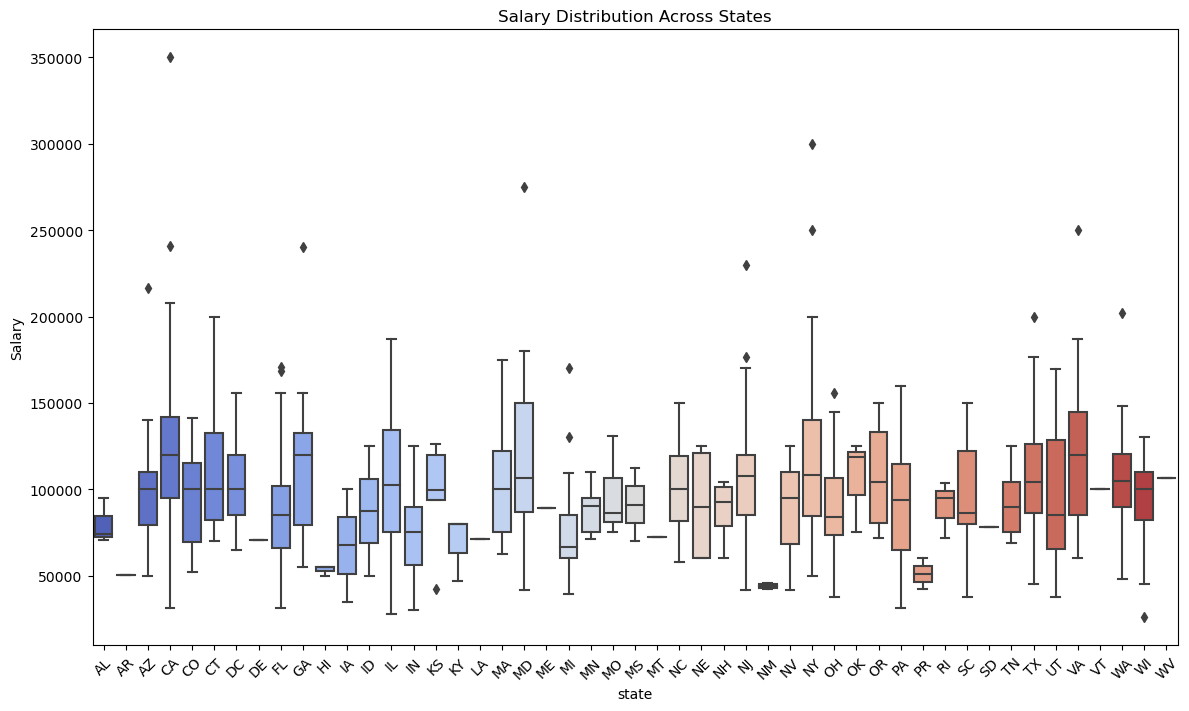

In [114]:
plt.figure(figsize=(14,8))
sns.boxplot(data=df_data_clean.sort_values('state'),x='state',y='salary_min',palette='coolwarm')
plt.ylabel('State')
plt.ylabel('Salary')
plt.title('Salary Distribution Across States')
plt.xticks(rotation = 45) 
plt.show()

In [174]:
all_skills = df_data_clean.explode('skills')['skills'].tolist()
skill_counts = {}
for skill in all_skills:
    skill_counts[skill] = skill_counts.get(skill, 0) + 1
skill_counts

{"['Go', 'JIRA']": 2,
 "['Java', 'C++', 'Go', 'Git', 'Linux', 'JIRA']": 1,
 "['JavaScript', 'Java', 'PHP', 'Go', 'SQL', 'HTML', 'CSS', 'Linux', 'MySQL']": 1,
 "['Java', 'SQL', 'HTML', 'CSS', 'XML', 'Azure']": 1,
 "['JavaScript', 'Java', 'Go', 'TypeScript', 'React']": 1,
 "['Python', 'Git']": 1,
 "['Java', 'Go', 'AWS', 'Azure', 'Linux']": 1,
 "['JavaScript', 'Java', 'C#', 'Go', 'React', 'Azure', 'Foundation']": 1,
 "['Python', 'JavaScript', 'Java', 'Go', 'TypeScript', 'React', 'Docker']": 1,
 "['JavaScript', 'Java', 'TypeScript', 'HTML', 'CSS', 'React']": 2,
 "['C#', 'SQL', 'MySQL']": 1,
 "['C#', 'SQL', 'AWS', 'Azure', 'PostgreSQL']": 1,
 "['Python', 'Java', 'C#', 'SQL', 'Docker', 'AWS', 'Linux', 'Unix', 'Foundation', 'JIRA']": 1,
 "['C#', 'Go', 'Git', 'Azure']": 1,
 "['Git']": 6,
 "['Go', 'Git']": 7,
 "['JavaScript', 'Java', 'C#', 'SQL', 'HTML', 'CSS', 'Spring', 'Git', 'Linux']": 1,
 "['Go', 'SQL', 'JSON', 'XML', 'Windows']": 1,
 "['C++', 'Windows']": 2,
 "['SQL']": 5,
 "['Python', 'Ja

In [125]:
new_york = df_data_clean.query("state == 'NY'")
new_york.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 31 to 3495
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   job_title         41 non-null     object 
 1   company_name      41 non-null     object 
 2   company_location  41 non-null     object 
 3   salary            41 non-null     object 
 4   skills            41 non-null     object 
 5   salary_min        41 non-null     float64
 6   state             41 non-null     object 
 7   work_mode         41 non-null     object 
dtypes: float64(1), object(7)
memory usage: 2.9+ KB
